Loading and preparing the dataset...
Dataset successfully loaded!

Data has been resampled to daily total sales.


Order Date
2015-01-03      16.448
2015-01-04     288.060
2015-01-05      19.536
2015-01-06    4407.100
2015-01-07      87.158
Freq: D, Name: Sales, dtype: float64


Plotting daily sales over time...


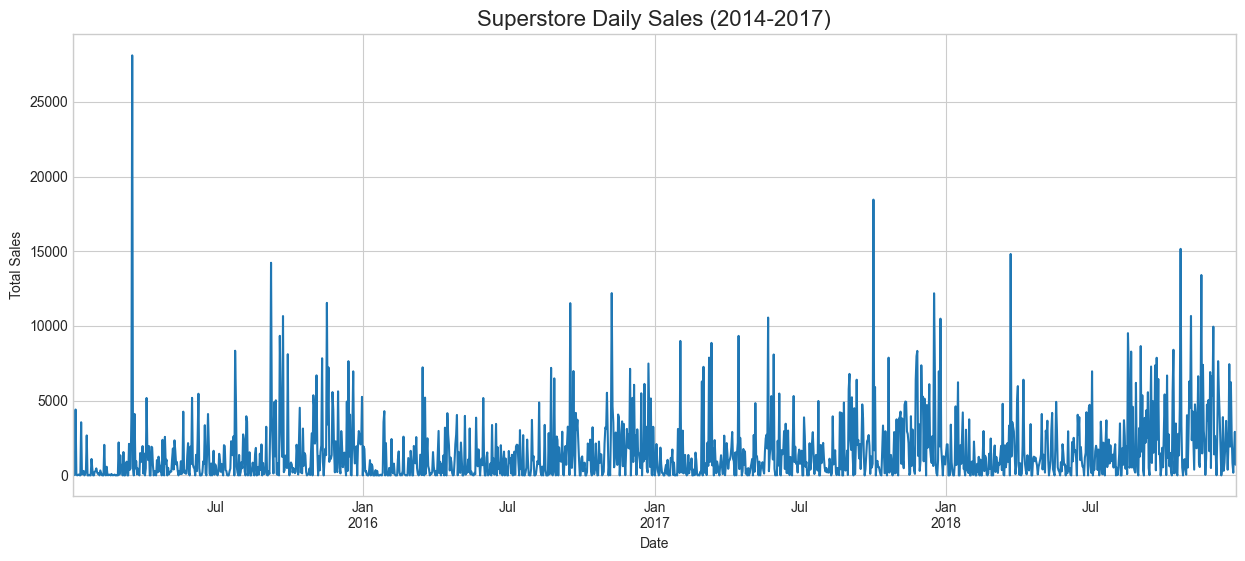

--- New Date-Based Features Created ---


,Sales,year,month,day,day_of_week,week_of_year,quarter
Order Date,,,,,,,
2015-01-03,16.448,2015,1,3,5,1,1
2015-01-04,288.060,2015,1,4,6,1,1
2015-01-05,19.536,2015,1,5,0,2,1
2015-01-06,4407.100,2015,1,6,1,2,1
2015-01-07,87.158,2015,1,7,2,2,1



--- Data Split Complete ---
Training data runs from 2015-01-03 to 2016-12-31
Testing data runs from 2017-01-01 to 2018-12-30
Training the XGBoost forecasting model...
Model training complete.

Model Performance (RMSE): $2,349.40
This is the average dollar amount the forecast was off by each day.


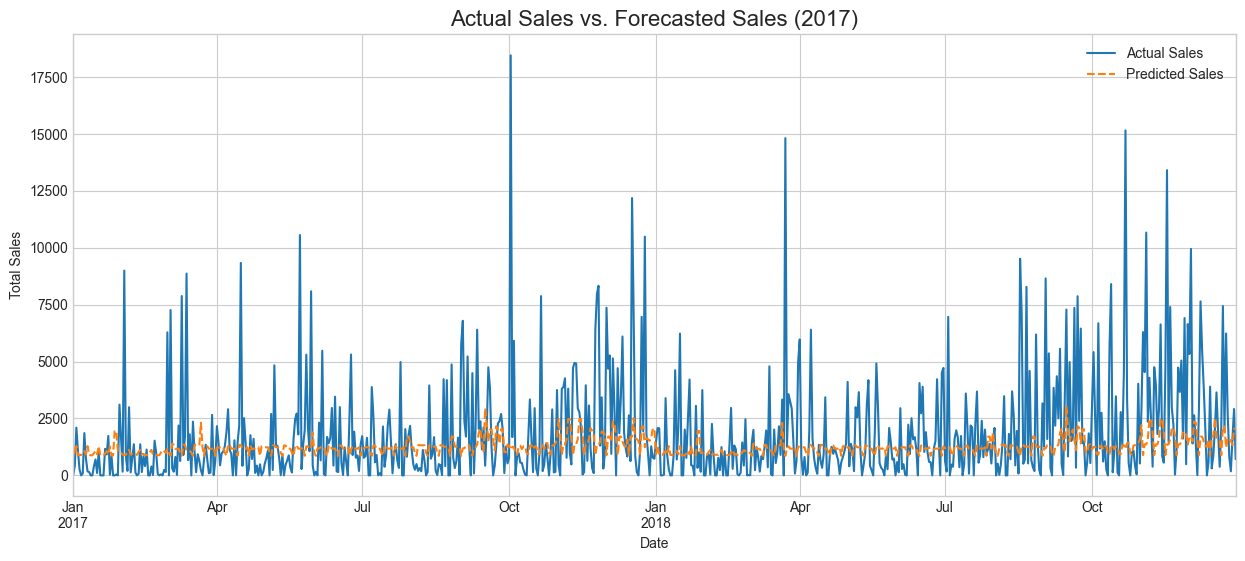

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

print("Loading and preparing the dataset...")

try:
    df = pd.read_csv('train.csv')
    print("Dataset successfully loaded!")
except FileNotFoundError:
    print("File not found! Make sure 'train.csv' is in your project folder.")

# --- Prepare the Time-Series ---
# NEW LINE: Manually convert the 'Order Date' column to a proper datetime format.
df['Order Date'] = pd.to_datetime(df['Order Date'], dayfirst=True)

# 1. Set the 'Order Date' as the index of our table.
df.set_index('Order Date', inplace=True)

# 2. We are interested in total sales. Let's select just the 'Sales' column.
sales_data = df['Sales']

# 3. The data is transactional. Let's resample it to get the total daily sales.
daily_sales = sales_data.resample('D').sum()

print("\nData has been resampled to daily total sales.")
display(daily_sales.head())

# --- Visualize the Time-Series ---
print("\nPlotting daily sales over time...")
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(15, 6))
daily_sales.plot()
plt.title('Superstore Daily Sales (2014-2017)', fontsize=16)
plt.ylabel('Total Sales')
plt.xlabel('Date')
plt.show()

# Create a new DataFrame for our features
df_features = pd.DataFrame(index=daily_sales.index)
df_features['Sales'] = daily_sales

# --- Create time-based features from the index ---
df_features['year'] = df_features.index.year
df_features['month'] = df_features.index.month
df_features['day'] = df_features.index.day
df_features['day_of_week'] = df_features.index.dayofweek  # Monday=0, Sunday=6
df_features['week_of_year'] = df_features.index.isocalendar().week.astype(int)
df_features['quarter'] = df_features.index.quarter

print("--- New Date-Based Features Created ---")
display(df_features.head())

# --- Prepare Features (X) and Target (y) ---
X = df_features.drop('Sales', axis=1)
y = df_features['Sales']

# --- Time-Based Train-Test Split ---
# This is a crucial step in time-series forecasting.
# We train on the past and test on the most recent future.
split_date = '2017-01-01'
X_train = X[X.index < split_date]
X_test = X[X.index >= split_date]
y_train = y[y.index < split_date]
y_test = y[y.index >= split_date]

print("\n--- Data Split Complete ---")
print(f"Training data runs from {X_train.index.min().date()} to {X_train.index.max().date()}")
print(f"Testing data runs from {X_test.index.min().date()} to {X_test.index.max().date()}")

import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np

print("Training the XGBoost forecasting model...")

# --- Train the XGBoost Model ---
# We initialize an XGBoost Regressor model
model = xgb.XGBRegressor(
    n_estimators=1000,         # Number of trees to build
    learning_rate=0.01,        # How quickly the model learns
    early_stopping_rounds=10,  # Stop training if performance doesn't improve
    objective='reg:squarederror'
)

# Train the model on the 2014-2016 data
# We'll also tell it to evaluate its performance on the 2017 test data as it trains
model.fit(X_train, y_train,
          eval_set=[(X_test, y_test)],
          verbose=False) # verbose=False keeps the training output clean

print("Model training complete.")

# --- Make Predictions on the 2017 Data ---
predictions = model.predict(X_test)

# --- Evaluate the Model ---
# We'll use Root Mean Squared Error (RMSE) to see how far off our predictions are on average
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"\nModel Performance (RMSE): ${rmse:,.2f}")
print("This is the average dollar amount the forecast was off by each day.")

# --- Visualize the Forecast vs. Actual Sales ---
# Create a DataFrame to easily plot the results
results_df = pd.DataFrame({'Actual Sales': y_test, 'Predicted Sales': predictions})

plt.figure(figsize=(15, 6))
# Plot the actual sales in a solid line
results_df['Actual Sales'].plot(style='-', label='Actual Sales')
# Plot our model's forecast in a dashed line
results_df['Predicted Sales'].plot(style='--', label='Predicted Sales')

plt.title('Actual Sales vs. Forecasted Sales (2017)', fontsize=16)
plt.ylabel('Total Sales')
plt.xlabel('Date')
plt.legend()
plt.show()